In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import calendar
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline     import Pipeline
from sklearn.compose      import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA

# exploratory data analysis

In [2]:
data = pd.read_csv('Data.csv')
data

,cc_num,year,month,HOM_tag,HOM_total,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,...,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq,next_HOM_total,dob,gender,job
0,2703186189652095,2019,1,1,2904.31,218.73,4,90.69,3,67.67,...,557.81,5,140.54,7,12.16,2,5513.39,1988-03-09,F,"Psychologist, counselling"
1,2703186189652095,2019,1,2,5513.39,476.50,7,152.08,2,0.00,...,1941.28,6,620.88,5,22.97,3,3696.99,1988-03-09,F,"Psychologist, counselling"
2,2703186189652095,2019,2,1,3696.99,244.19,2,22.93,1,0.00,...,1422.89,2,176.81,7,0.00,0,2847.65,1988-03-09,F,"Psychologist, counselling"
3,2703186189652095,2019,2,2,2847.65,85.84,2,317.45,6,0.00,...,216.05,3,758.24,4,0.00,0,4785.08,1988-03-09,F,"Psychologist, counselling"
4,2703186189652095,2019,3,1,4785.08,245.70,3,51.88,2,152.95,...,584.38,1,297.77,9,0.00,0,4127.63,1988-03-09,F,"Psychologist, counselling"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42671,5410056176712193,2020,10,1,621.74,33.59,1,9.75,1,63.88,...,34.74,5,10.46,2,0.00,0,1876.81,1989-10-19,M,Art therapist
42672,5410056176712193,2020,10,2,1876.81,0.00,0,165.12,3,76.00,...,0.00,0,1515.34,3,0.00,0,626.29,1989-10-19,M,Art therapist
42673,5410056176712193,2020,11,1,626.29,150.61,2,21.22,2,0.00,...,0.00,0,0.00,0,0.00,0,648.02,1989-10-19,M,Art therapist
42674,5410056176712193,2020,11,2,648.02,61.56,2,28.61,2,0.00,...,110.68,1,7.48,1,9.42,1,1606.97,1989-10-19,M,Art therapist


In [3]:
# age from DOB
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
today = pd.Timestamp.today()
data['age'] = ((today - data['dob']).dt.days / 365.25).astype(int)


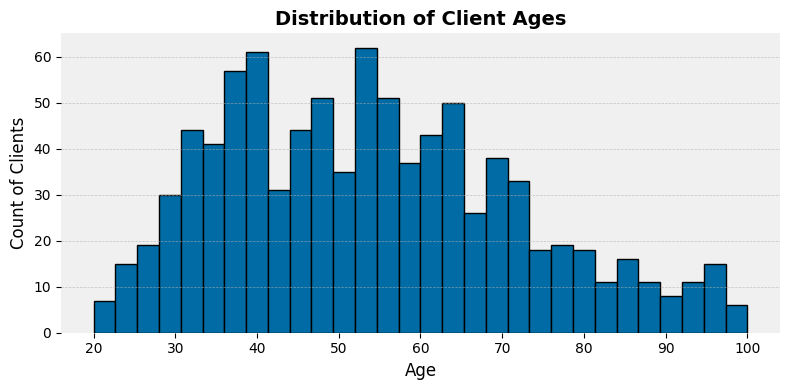

In [4]:
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(figsize=(8, 4))

# Plot the histogram
ax.hist(data.drop_duplicates(subset='cc_num')['age'], bins=30, edgecolor='black')

# Formatting
ax.set_facecolor('#F0F0F0')
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Axis labels and title
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Count of Clients', fontsize=12)
ax.set_title('Distribution of Client Ages', fontsize=14, weight='bold')

# Ticks
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

In [5]:
data.drop_duplicates(subset='cc_num')['age'].to_csv('age_distribution.csv')

In [6]:
print(f"data recording duration: {data['year'].unique()}")
print(f"number of clients: {data['cc_num'].nunique()}")

data recording duration: [2019 2020]
number of clients: 908


the data we have for each of the 908 clients range from January 2019 until the first half of December 2020 (23.5 months or 47 half months). <br>47 half months x 908 clients = 42676 rows of the whole dataset

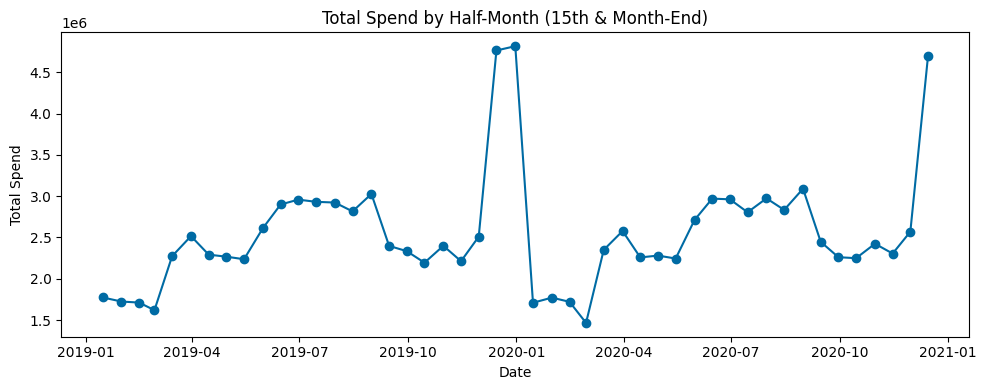

In [7]:
data['period_day'] = data.apply(
    lambda row: 15 
        if row['HOM_tag']==1 
        else calendar.monthrange(row['year'], row['month'])[1],
    axis=1
)

data['HOM_period_date'] = pd.to_datetime({
    'year':  data['year'],
    'month': data['month'],
    'day':   data['period_day']
})

total_by_period = (
    data.groupby('HOM_period_date')['HOM_total']
      .sum()
      .reset_index(name='total_spend')
)

# And you can plot with an actual date axis:
plt.figure(figsize=(10,4))
plt.plot(total_by_period['HOM_period_date'], total_by_period['total_spend'], marker='o')
plt.title("Total Spend by Half-Month (15th & Month-End)")
plt.xlabel("Date")
plt.ylabel("Total Spend")
plt.tight_layout()
plt.show()


C:\Users\jed jerrel escaran\AppData\Local\Temp\ipykernel_10732\2420790864.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('HOM_period')[cat_cols]


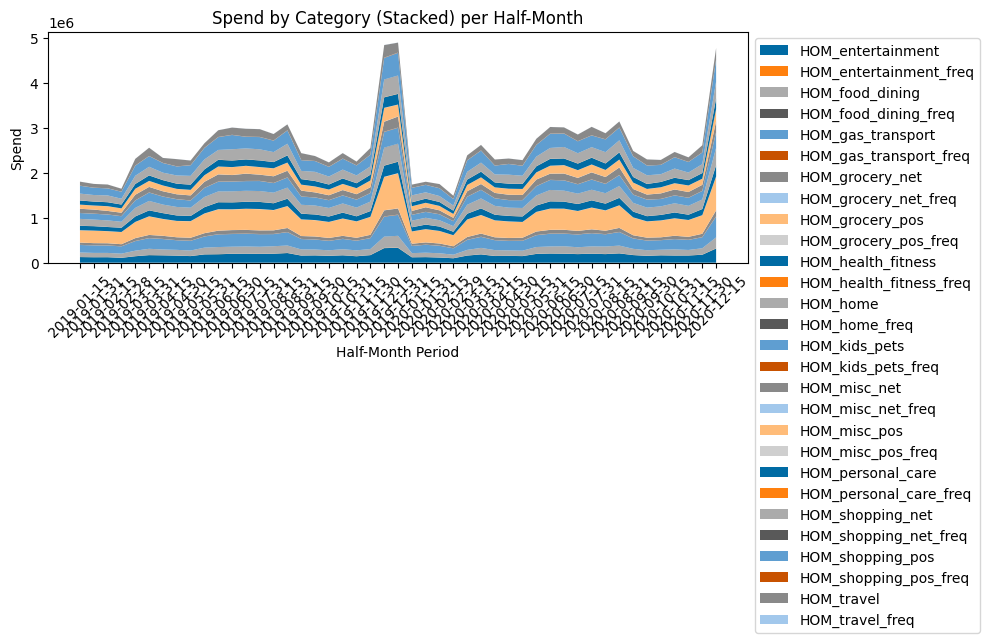

In [8]:
data['HOM_period'] = pd.Categorical(
    data['HOM_period_date'].dt.strftime('%Y-%m-%d'),
    ordered=True,
    categories=sorted(data['HOM_period_date'].dt.strftime('%Y-%m-%d').unique())
)
# dataa = data.drop('HOM_period_date', axis=1)
# Assumes your category cols are named like 'HOM_food_dining', 'HOM_gas_transport', etc.
cat_cols = [c for c in data.columns if c.startswith('HOM_') and c not in ['HOM_total', 'HOM_period', 'HOM_tag','HOM_period_date']]
category_by_period = (
    data.groupby('HOM_period')[cat_cols]
      .sum()
      .reset_index()
)

plt.figure(figsize=(10, 5))
plt.stackplot(
    category_by_period['HOM_period'],
    [category_by_period[c] for c in cat_cols],
    labels=cat_cols
)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Spend by Category (Stacked) per Half-Month")
plt.xlabel("Half-Month Period")
plt.ylabel("Spend")
plt.tight_layout()
plt.show()

In [9]:
data.isna().sum()


cc_num                     0
year                       0
month                      0
HOM_tag                    0
HOM_total                  0
HOM_entertainment          0
HOM_entertainment_freq     0
HOM_food_dining            0
HOM_food_dining_freq       0
HOM_gas_transport          0
HOM_gas_transport_freq     0
HOM_grocery_net            0
HOM_grocery_net_freq       0
HOM_grocery_pos            0
HOM_grocery_pos_freq       0
HOM_health_fitness         0
HOM_health_fitness_freq    0
HOM_home                   0
HOM_home_freq              0
HOM_kids_pets              0
HOM_kids_pets_freq         0
HOM_misc_net               0
HOM_misc_net_freq          0
HOM_misc_pos               0
HOM_misc_pos_freq          0
HOM_personal_care          0
HOM_personal_care_freq     0
HOM_shopping_net           0
HOM_shopping_net_freq      0
HOM_shopping_pos           0
HOM_shopping_pos_freq      0
HOM_travel                 0
HOM_travel_freq            0
next_HOM_total             0
dob           

0 nan or missing values

In [10]:
ID_bimonthly_transactions = data[['cc_num','year','month','HOM_total']].copy()
ID_bimonthly_transactions['cc_id'] = pd.factorize(ID_bimonthly_transactions['cc_num'])[0]+1
ID_bimonthly_transactions = ID_bimonthly_transactions.set_index(['cc_id'])
ID_bimonthly_transactions.head(n=95)

,cc_num,year,month,HOM_total
cc_id,,,,
1,2703186189652095,2019,1,2904.31
1,2703186189652095,2019,1,5513.39
1,2703186189652095,2019,2,3696.99
1,2703186189652095,2019,2,2847.65
1,2703186189652095,2019,3,4785.08
...,...,...,...,...
2,630423337322,2020,10,5113.35
2,630423337322,2020,11,3668.19
2,630423337322,2020,11,5079.88


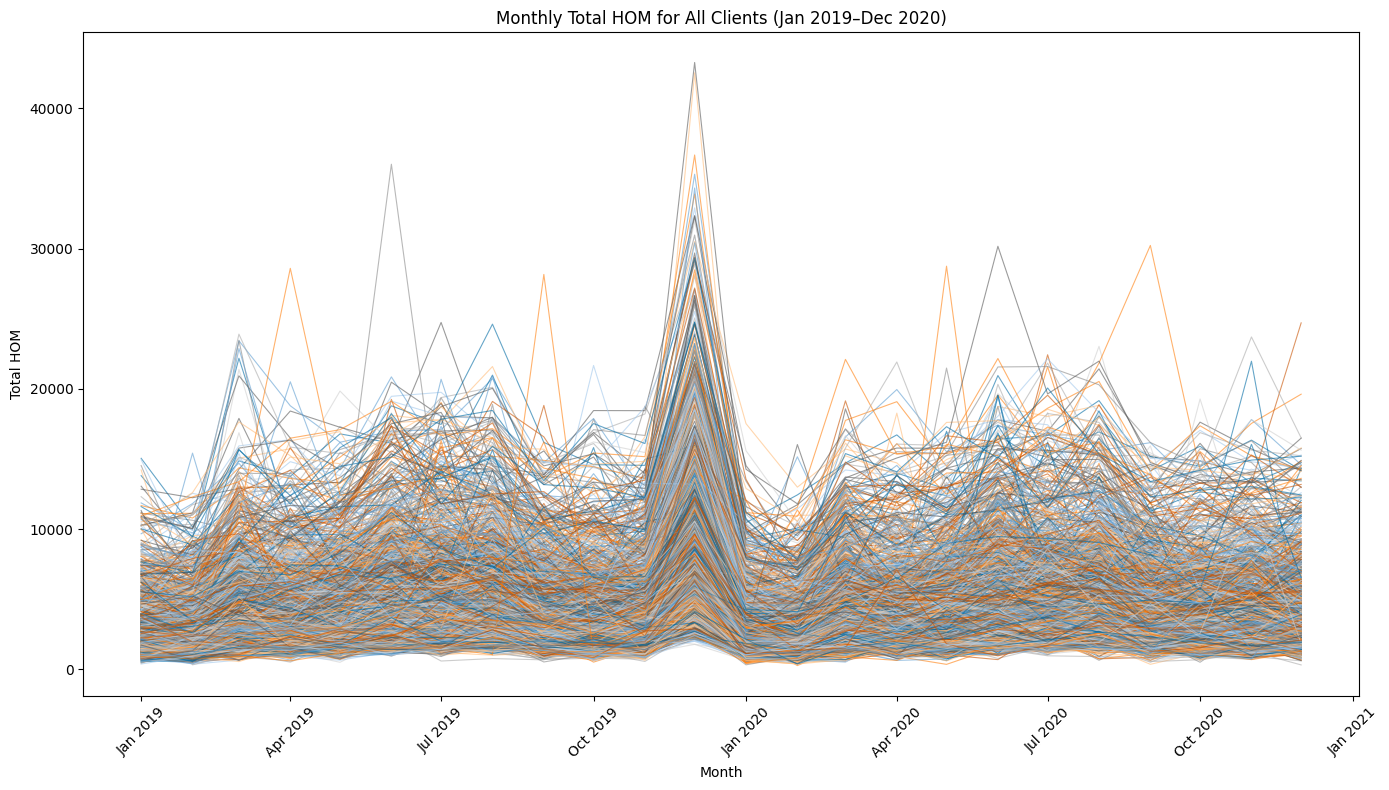

In [11]:
agg = (ID_bimonthly_transactions.groupby(['cc_id','year','month'])['HOM_total'].sum())
# print(agg.head(n=50))

transactions_per_month = agg.reset_index(name='HOM_total')
transactions_per_month['period'] = pd.to_datetime(
    transactions_per_month['year'].astype(str) + '-' + transactions_per_month['month'].astype(str) + '-01'
)
transactions_per_month['month_label'] = transactions_per_month['period'].dt.strftime('%b %Y')  # e.g. "Jan 2019"

plt.figure(figsize=(14, 8))

# Loop once over each client, plotting onto the same axes
for cc_id, grp in transactions_per_month.groupby('cc_id'):
    grp = grp.sort_values('period')
    plt.plot(grp['period'], grp['HOM_total'],
             linewidth=0.8,        # thin lines so 908 fit
             alpha=0.6)            # slight transparency

# Format the x-axis to show major ticks at each quarter (or year)
plt.gca().xaxis.set_major_locator(
    plt.matplotlib.dates.MonthLocator(bymonth=[1,4,7,10])  # Jan, Apr, Jul, Oct
)
plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%b %Y')
)

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total HOM')
plt.title('Monthly Total HOM for All Clients (Jan 2019–Dec 2020)')

# Legend for 908 lines would be unreadable—omit it
# plt.legend(title='Client ID', bbox_to_anchor=(1.05, 1), ncol=2, fontsize='small')

plt.tight_layout()
plt.show()

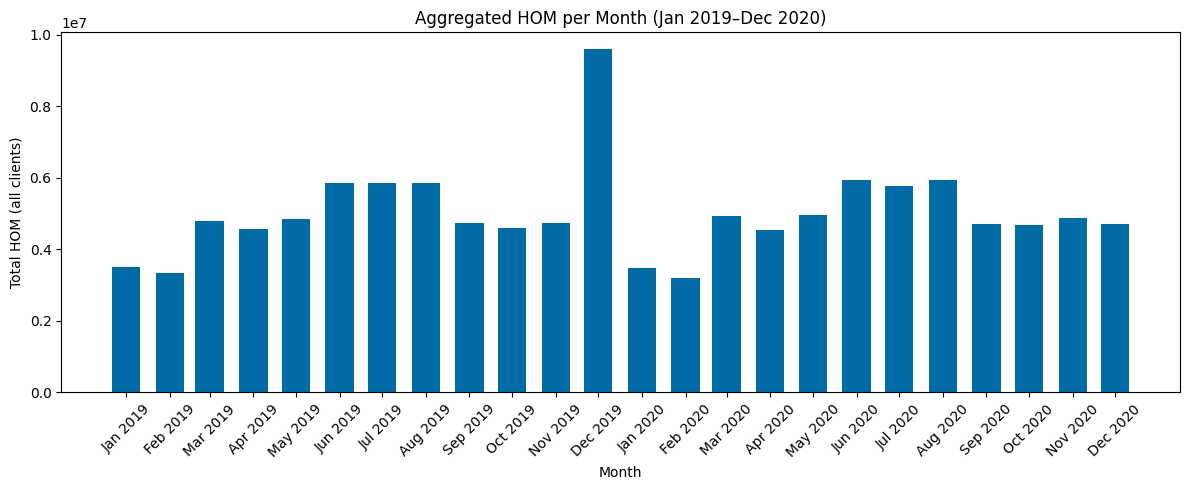

In [12]:
# 1. Sum across all cc_id for each period
monthly_totals = (
    transactions_per_month
      .groupby('period', as_index=False)['HOM_total']
      .sum()
)

# 2. Bar plot
plt.figure(figsize=(12,5))
plt.bar(monthly_totals['period'], monthly_totals['HOM_total'], width=20)
plt.xticks(
    monthly_totals['period'],
    monthly_totals['period'].dt.strftime('%b %Y'),
    rotation=45
)
plt.xlabel('Month')
plt.ylabel('Total HOM (all clients)')
plt.title('Aggregated HOM per Month (Jan 2019–Dec 2020)')
plt.tight_layout()
plt.show()


In [13]:
specific_transactions_per_month = data.copy()
specific_transactions_per_month['cc_id'] = pd.factorize(specific_transactions_per_month['cc_num'])[0]+1
specific_transactions_per_month.set_index(['cc_id'])
specific_transactions_per_month = specific_transactions_per_month.drop(['HOM_period','cc_num','dob','gender','job','HOM_tag','next_HOM_total','HOM_period_date','age','period_day'], axis=1)
specific_transactions_per_month.set_index('cc_id')

agg2 = (specific_transactions_per_month.groupby(['cc_id', 'year', 'month']).sum())
agg2

HOM_total  HOM_entertainment  HOM_entertainment_freq  \
cc_id year month                                                         
1     2019 1        8417.70             695.23                      11   
           2        6544.64             330.03                       4   
           3        8912.71             548.74                       7   
           4        5812.38             521.41                       8   
           5       10836.84             963.90                       9   
...                     ...                ...                     ...   
908   2020 8        1435.73              31.20                       3   
           9        1394.92              92.53                       1   
           10       2498.55              33.59                       1   
           11       1274.31             212.17                       4   
           12       1606.97              85.68                       2   

                  HOM_food_dining  HOM_food_dining_freq  HOM_gas_transport  \
cc_id year month                                                             
1     2019 1               242.77                     5              67.67   
           2               340.38                     7               0.00   
           3               228.29                     5             297.62   
           4               680.82                    10              74.22   
           5               189.77                     4             114.80   
...                           ...                   ...                ...   
908   2020 8               171.36                     5             232.86   
           9                43.93                     2             376.29   
           10              174.87                     4             139.88   
           11               49.83                     4               0.00   
           12               97.22                     3             222.57   

                  HOM_gas_transport_freq  HOM_grocery_net  \
cc_id year month                                            
1     2019 1                           1           441.24   
           2                           0           298.72   
           3                           4           326.30   
           4                           1           566.88   
           5                           2           466.97   
...                                  ...              ...   
908   2020 8                           3           154.24   
           9                           6           153.52   
           10                          2            96.87   
           11                          0           126.34   
           12                          3           107.47   

                  HOM_grocery_net_freq  HOM_grocery_pos  ...  HOM_misc_pos  \
cc_id year month                                         ...                 
1     2019 1                         7          1426.87  ...        558.06   
           2                         4          1371.99  ...        289.75   
           3                         5          2771.24  ...        650.46   
           4                         9          1199.59  ...        190.14   
           5                         7          2166.70  ...        696.63   
...                                ...              ...  ...           ...   
908   2020 8                         3           204.44  ...         11.69   
           9                         3            98.77  ...        118.83   
           10                        2            88.34  ...          0.00   
           11                        3           379.76  ...          9.27   
           12                        2           125.65  ...          0.00   

                  HOM_misc_pos_freq  HOM_personal_care  \
cc_id year month                                         
1     2019 1                      4             316.04   
           2                      9             202.44   

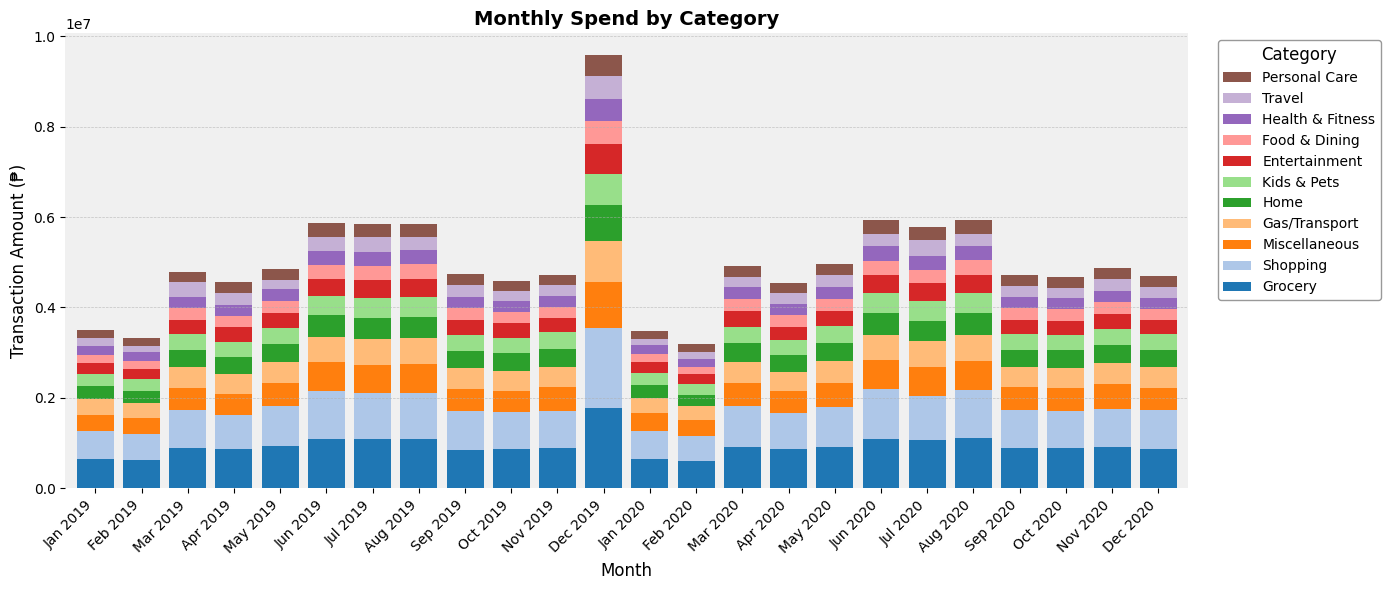

In [14]:
stack_df = agg2.reset_index().copy()
stack_df['period'] = pd.to_datetime(
    stack_df['year'].astype(str) + '-' + stack_df['month'].astype(str) + '-01'
)

# 1) Identify your HOM-category columns
category_cols = [
    c for c in stack_df.columns
    if c.startswith('HOM_')
       and c != 'HOM_total'
       and not c.endswith('_freq')
]

# 2) Aggregate by month
monthly_by_cat = (
    stack_df
      .groupby('period')[category_cols]
      .sum()
      .sort_index()
)

# 0a) Identify net/pos bases
net_cols  = [c for c in monthly_by_cat.columns if c.endswith('_net')]
pos_cols  = [c for c in monthly_by_cat.columns if c.endswith('_pos')]
bases     = {c[:-4] for c in net_cols}  # strip '_net' to get base names

# 1) Create a new DataFrame where we combine net+pos for each base
monthly_combined = monthly_by_cat.copy()
for base in bases:
    net_col = f"{base}_net"
    pos_col = f"{base}_pos"
    monthly_combined[f"{base}"] = (
        monthly_combined[net_col] + monthly_combined[pos_col]
    )

# 2) Drop the old _net and _pos columns
drop_cols = [f"{base}_net" for base in bases] + [f"{base}_pos" for base in bases]
monthly_combined = monthly_combined.drop(columns=drop_cols)

# 3) Now re-sort columns by total descending (largest → smallest)
overall_totals = monthly_combined.sum(axis=0)
sorted_cols    = overall_totals.sort_values(ascending=False).index
monthly_sorted = monthly_combined[sorted_cols]

# 4) Build pretty labels for these new column names
label_map = {
    'HOM_entertainment':  'Entertainment',
    'HOM_gas_transport':  'Gas/Transport',
    'HOM_food_dining':    'Food & Dining',
    'HOM_grocery':        'Grocery',
    'HOM_health_fitness': 'Health & Fitness',
    'HOM_home':           'Home',
    'HOM_kids_pets':      'Kids & Pets',
    'HOM_misc':           'Miscellaneous',
    'HOM_personal_care':  'Personal Care',
    'HOM_shopping':       'Shopping',
    'HOM_travel':         'Travel'
}
pretty_labels = [label_map[c] for c in sorted_cols]

# # 1a. Sum each row (month) across categories
monthly_totals = monthly_combined.sum(axis=1)

# 1b. Turn to row‐wise fractions
monthly_pct = monthly_combined.div(monthly_totals, axis=0)

# 1c. Drop December 2019
#    monthly_pct.index is a DatetimeIndex, so we can do:
monthly_pct = monthly_pct[monthly_pct.index != '2019-12-01']
# 2. Average across months
avg_pct        = monthly_pct.mean(axis=0)
avg_pct_sorted = avg_pct.sort_values(ascending=False)

labels = [label_map[c] for c in avg_pct_sorted.index]
sizes  = avg_pct_sorted.values

# 2) Pick distinct colors (one per slice) from a Tableau‐style palette
cmap   = plt.get_cmap('tab20').colors
colors = cmap[:len(sizes)]

# 5) Plot with BI‐style formatting
plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(14, 6))

monthly_sorted.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.8,
    # cmap=plt.get_cmap('tab20')
    color= colors
)

# Clean background & grid
ax.set_facecolor('#F0F0F0')
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(False)

# X‐axis formatting
ax.set_xticklabels(
    [d.strftime('%b %Y') for d in monthly_sorted.index],
    rotation=45,
    ha='right',
    fontsize=10
)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    pretty_labels[::-1],
    title='Category',
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=10,
    title_fontsize=12
)

# Titles & labels
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Transaction Amount (₱)', fontsize=12)
ax.set_title('Monthly Spend by Category', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()



In [15]:
sizes

array([0.18749746, 0.17690547, 0.1073349 , 0.09580866, 0.08148287,
       0.07477681, 0.06787216, 0.05346342, 0.0533911 , 0.05127553,
       0.05019163])

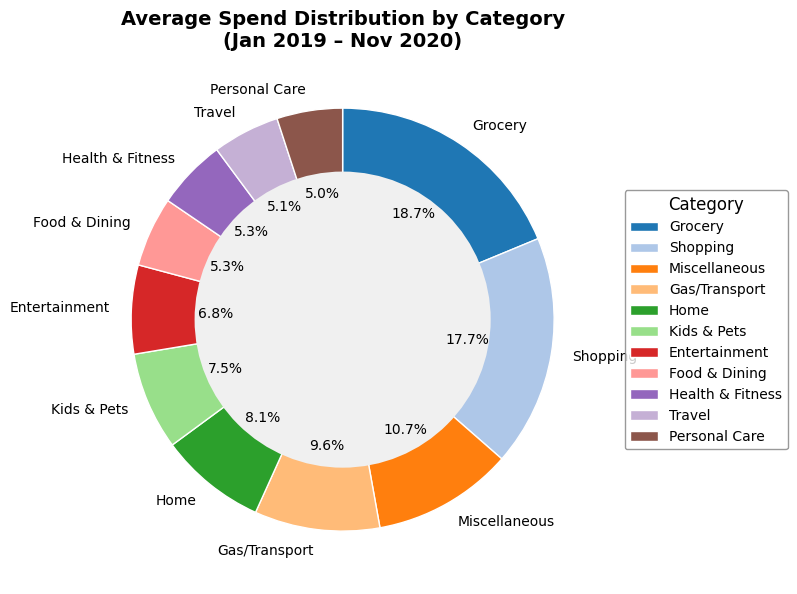

In [16]:
# 1) Prepare labels & sizes (assumes avg_pct_sorted and label_map_combined are defined)



# 3) Apply BI‐style formatting
plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('#F0F0F0')

# 4) Draw the donut chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=pretty_labels,
    colors=colors,
    autopct='%.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor':'white', 'linewidth': 1},
    textprops={'fontsize': 10, 'color': 'black'}
)

# 5) Add center circle for the “donut” look
centre = plt.Circle((0, 0), 0.70, fc='#F0F0F0')
ax.add_artist(centre)

# 6) Title
ax.set_title(
    'Average Spend Distribution by Category\n(Jan 2019 – Nov 2020)',
    fontsize=14, weight='bold'
)

# 7) Legend to the side
ax.legend(
    wedges, pretty_labels,
    title='Category',
    loc='center left',
    bbox_to_anchor=(1.02, 0, 0.5, 1),
    frameon=True, facecolor='white', edgecolor='gray',
    fontsize=10, title_fontsize=12
)

plt.tight_layout()
plt.show()


In [17]:
sizes

array([0.18749746, 0.17690547, 0.1073349 , 0.09580866, 0.08148287,
       0.07477681, 0.06787216, 0.05346342, 0.0533911 , 0.05127553,
       0.05019163])

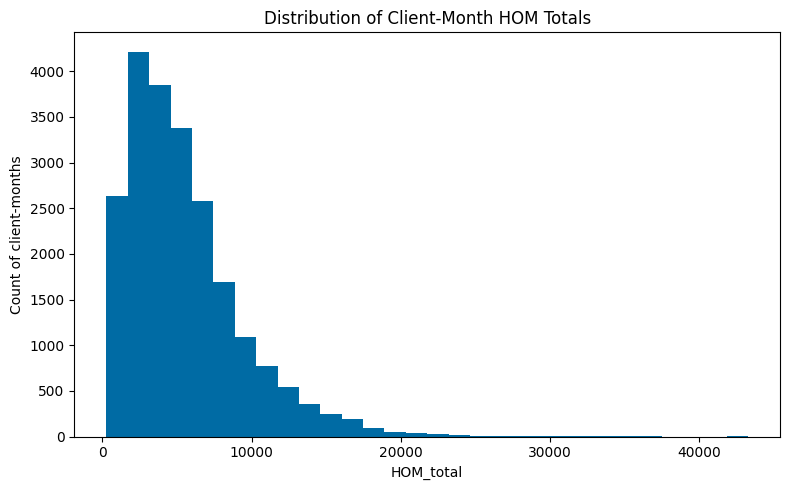

In [18]:
plt.figure(figsize=(8,5))
plt.hist(transactions_per_month['HOM_total'], bins=30)
plt.xlabel('HOM_total')
plt.ylabel('Count of client-months')
plt.title('Distribution of Client-Month HOM Totals')
plt.tight_layout()
plt.show()


In [19]:
occ_counts = (
    data
      .groupby('job')['cc_num']   # a) select the client_id per occupation
      .nunique()                            # b) count distinct client_ids in each group
      .reset_index(name='num_clients')      # c) make a DataFrame and name the new count column
)

# 3. (Optional) Sort descending so the most‐common occupations come first:
occ_counts = occ_counts.sort_values('num_clients', ascending=False)

# 4. (Optional) Reset the index to clean up after sorting:
occ_counts = occ_counts.reset_index(drop=True)

print(occ_counts)

                          job  num_clients
0          Materials engineer            6
1             Naval architect            6
2           Film/video editor            5
3              Science writer            5
4    Surveyor, land/geomatics            5
..                        ...          ...
470            Hydrogeologist            1
471             Hotel manager            1
472       Hospital pharmacist            1
473  Horticultural consultant            1
474                    Writer            1

[475 rows x 2 columns]


# RFM not much

In [20]:
data['client_id'] = pd.factorize(data['cc_num'])[0] + 1

analysis_date = data['HOM_period_date'].max()

last_tx = (
    data.groupby('client_id')['HOM_period_date']
      .max()
      .reset_index(name='last_tx_date')
)
last_tx['recency_days'] = (analysis_date - last_tx['last_tx_date']).dt.days

freq = (
    data[data['HOM_total'] > 0]
      .groupby('client_id')['HOM_period_date']
      .nunique()
      .reset_index(name='frequency')
)

mon = (
    data.groupby('client_id')['HOM_total']
      .sum()
      .reset_index(name='monetary')
)

rfm = last_tx.merge(freq, on='client_id').merge(mon, on='client_id')
rfm.head(n=20)

,client_id,last_tx_date,recency_days,frequency,monetary
0,1,2020-12-15,0,47,246952.31
1,2,2020-12-15,0,47,230015.64
2,3,2020-12-15,0,47,45948.51
3,4,2020-12-15,0,47,50180.61
4,5,2020-12-15,0,47,260177.45
5,6,2020-12-15,0,47,46355.54
6,7,2020-12-15,0,47,248687.42
7,8,2020-12-15,0,47,89951.05
8,9,2020-12-15,0,47,85290.90
9,10,2020-12-15,0,47,129284.13


In [21]:

# Helper to assign quintile scores, or top score if constant
def safe_qcut(series, q=5, ascending=True):
    if series.nunique() < q:
        # everyone gets max score
        return pd.Series(q, index=series.index)
    else:
        labels = list(range(1, q+1))
        # for recency we want low→high, so reverse labels
        if not ascending:
            labels = labels[::-1]
        return pd.qcut(series, q, labels=labels).astype(int)

# R: lower recency = better → ascending=False (so small → high score)
rfm['R_score'] = safe_qcut(rfm['recency_days'], q=5, ascending=False)

# F: higher frequency = better → ascending=True
rfm['F_score'] = safe_qcut(rfm['frequency'], q=5, ascending=True)

# M: higher monetary = better → ascending=True
rfm['M_score'] = safe_qcut(rfm['monetary'], q=5, ascending=True)

# Combine codes & total
rfm['RFM_code']  = rfm['R_score'].astype(str) + \
                   rfm['F_score'].astype(str) + \
                   rfm['M_score'].astype(str)
rfm['RFM_score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

# Segment labeling
def label_segment(score):
    if score >= 13: return 'Champions'
    if score >= 10: return 'Loyal Customers'
    if score >=  7: return 'Potential Loyalist'
    if score >=  4: return 'At Risk'
    return 'Hibernating'

rfm['segment'] = rfm['RFM_score'].apply(label_segment)

# Inspect
print(rfm[['client_id','R_score','F_score','M_score','RFM_code','RFM_score','segment']])
print("\nSegment counts:")
print(rfm['segment'].value_counts())


     client_id  R_score  F_score  M_score RFM_code  RFM_score          segment
0            1        5        5        5      555         15        Champions
1            2        5        5        5      555         15        Champions
2            3        5        5        1      551         11  Loyal Customers
3            4        5        5        1      551         11  Loyal Customers
4            5        5        5        5      555         15        Champions
..         ...      ...      ...      ...      ...        ...              ...
903        904        5        5        1      551         11  Loyal Customers
904        905        5        5        1      551         11  Loyal Customers
905        906        5        5        1      551         11  Loyal Customers
906        907        5        5        1      551         11  Loyal Customers
907        908        5        5        1      551         11  Loyal Customers

[908 rows x 7 columns]

Segment counts:
segment
Cha

In [22]:
# 1a) Demographics per client
socdem = (
    data[['client_id','age','gender','job']]
      .drop_duplicates(subset='client_id')
      .set_index('client_id')
)

# 1b) Average spend per category per client
avg_spend = (
    data.groupby('client_id')[cat_cols]
      .mean()
)

profile = (
    rfm.set_index('client_id')[['segment']]       # just the segment label
       .join(socdem)                                # add age/gender/occupation
       .join(avg_spend)                           # add mean category spends
       .reset_index()
)

seg_profile = profile.groupby('segment').agg({
    'age':        'median',
    'gender':     lambda x: x.value_counts(normalize=True).idxmax(),
    'job': lambda x: x.mode()[0],
    **{c: 'mean' for c in cat_cols}
}).reset_index()
seg_profile


,segment,age,gender,job,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,HOM_gas_transport_freq,...,HOM_misc_pos,HOM_misc_pos_freq,HOM_personal_care,HOM_personal_care_freq,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq
0,Champions,48.0,F,Film/video editor,261.105120,4.009252,194.004001,3.932813,348.230861,5.484208,...,216.972562,3.460394,187.189237,3.868241,310.527998,4.214171,387.544274,5.006246,200.956348,1.686824
1,Loyal Customers,59.0,M,Exercise physiologist,84.779311,1.528046,83.786034,1.464334,149.842503,2.327531,...,73.584230,1.223199,70.713939,1.505363,92.300866,1.407772,107.461604,1.805463,60.611590,0.730790


# kmeans

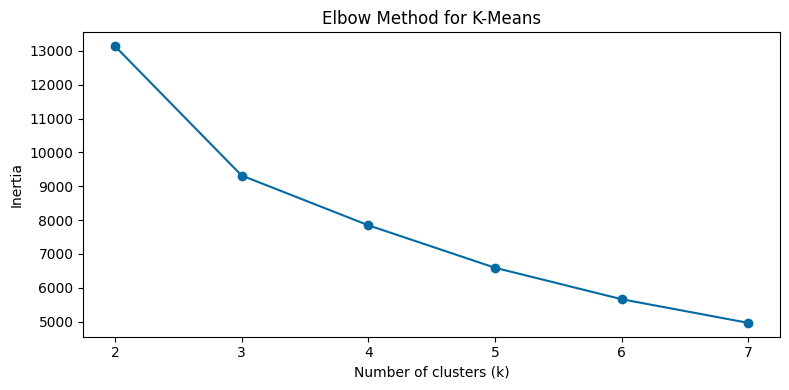

In [23]:
client_feats = (
    data.groupby('client_id')[cat_cols]
      .mean()
)

# 1) Prepare the feature matrix (exclude client_id index)
X = client_feats.reset_index().drop(columns='client_id').values

# 2) Scale all features to mean=0, σ=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Compute inertia for k=2…7
distortions = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    distortions.append(km.inertia_)

# 4) Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, distortions, marker='o')
plt.xticks(K)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.tight_layout()
plt.show()

In [24]:
# Fit with k=3
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
client_feats['cluster'] = km.fit_predict(X_scaled)+1

demo = (
    data[['client_id','age','gender','job']]
      .drop_duplicates(subset='client_id')
)

# Combine with cluster labels and average spend features
profile = client_feats.reset_index().merge(demo, on='client_id')

seg_profile = profile.groupby('cluster').agg({
    'age':        'median',
    'gender':     lambda x: x.mode()[0],
    'job': lambda x: x.mode()[0],
    **{c: 'mean' for c in client_feats.columns if c.endswith('_freq') or c in cat_cols}
}).reset_index()

seg_profile


,cluster,age,gender,job,HOM_entertainment,HOM_entertainment_freq,HOM_food_dining,HOM_food_dining_freq,HOM_gas_transport,HOM_gas_transport_freq,...,HOM_misc_pos,HOM_misc_pos_freq,HOM_personal_care,HOM_personal_care_freq,HOM_shopping_net,HOM_shopping_net_freq,HOM_shopping_pos,HOM_shopping_pos_freq,HOM_travel,HOM_travel_freq
0,1,55.0,F,Agricultural consultant,207.473395,3.645655,171.551839,3.372374,362.070546,5.746802,...,165.384487,2.880692,168.424416,3.538941,238.677874,3.663353,273.366129,4.251077,153.399054,1.646517
1,2,40.0,F,Exhibition designer,401.855088,5.384686,255.241676,5.665747,404.425405,6.345022,...,348.239150,5.111899,252.837053,5.237720,491.192477,6.100998,656.373744,7.375099,269.297528,2.034016
2,3,58.0,M,Exercise physiologist,97.359286,1.640350,93.480515,1.587184,146.910793,2.261577,...,83.430492,1.357897,76.855185,1.576771,109.539280,1.513992,132.087336,1.939825,90.955108,0.768360


In [25]:
counts = profile.groupby('cluster').size().reset_index(name='n_clients')
print(counts)

   cluster  n_clients
0        1        321
1        2        162
2        3        425


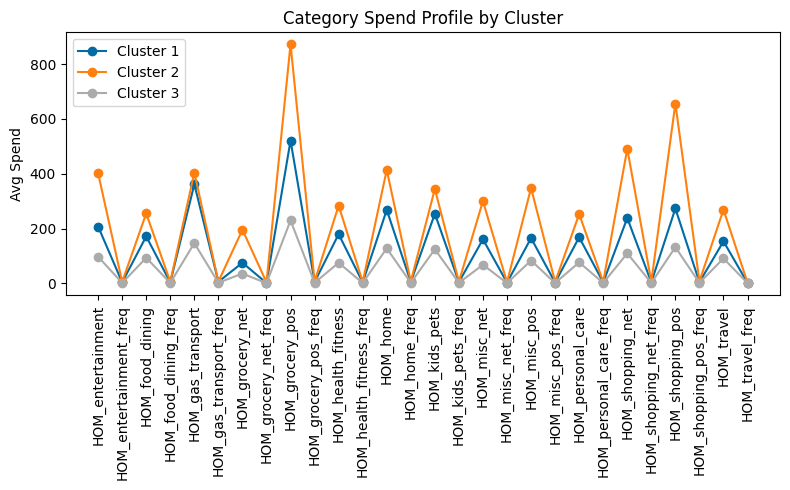

In [26]:
plt.figure(figsize=(8,5))
for c in seg_profile['cluster']:
    vals = seg_profile.loc[seg_profile['cluster']==c, cat_cols].values.flatten()
    plt.plot(cat_cols, vals, marker='o', label=f'Cluster {c}')

plt.xticks(rotation=90)
plt.ylabel("Avg Spend")
plt.title("Category Spend Profile by Cluster")
plt.legend()
plt.tight_layout()
plt.show()

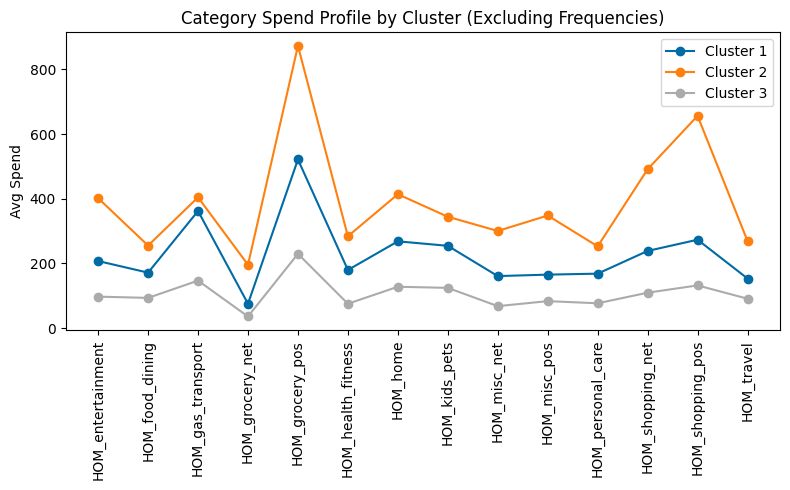

In [27]:
spend_cols = [col for col in cat_cols if not col.endswith('_freq')]

plt.figure(figsize=(8,5))
for c in seg_profile['cluster']:
    vals = seg_profile.loc[seg_profile['cluster'] == c, spend_cols].values.flatten()
    plt.plot(spend_cols, vals, marker='o', label=f'Cluster {c}')

plt.xticks(rotation=90)
plt.ylabel("Avg Spend")
plt.title("Category Spend Profile by Cluster (Excluding Frequencies)")
plt.legend()
plt.tight_layout()
plt.show()

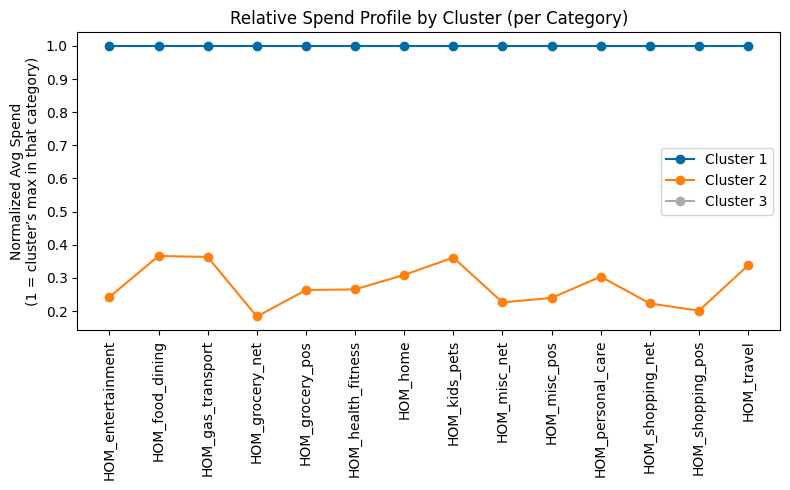

In [28]:
# 2) Compute the max per category across clusters
max_vals = seg_profile[spend_cols].max()

# 3) Build a normalized DataFrame
#    Each cell = original avg spend ÷ max(avg spend for that category)
normed = seg_profile[['cluster']].set_index('cluster').join(
    seg_profile[spend_cols].div(max_vals, axis=1)
)

# 4) Plot the normalized values
plt.figure(figsize=(8,5))
for c in normed.index:
    vals = normed.loc[c, spend_cols].values
    plt.plot(spend_cols, vals, marker='o', label=f'Cluster {c}')

plt.xticks(rotation=90)
plt.ylabel("Normalized Avg Spend\n(1 = cluster’s max in that category)")
plt.title("Relative Spend Profile by Cluster (per Category)")
plt.legend()
plt.tight_layout()
plt.show()

# models 

## linear reg

In [29]:
Q1 = total_by_period['total_spend'].quantile(0.25)
Q3 = total_by_period['total_spend'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = total_by_period[
    (total_by_period['total_spend'] < lower_bound) |
    (total_by_period['total_spend'] > upper_bound)
]['HOM_period_date'].tolist()

print("Outlier periods detected: \n", outliers)

# 4) Filter out those periods from df
data_filtered = data[~data['HOM_period_date'].isin(outliers)].copy()

data_filtered = data_filtered.loc[
    ~(
        (data_filtered['HOM_period_date'].dt.month == 11)
        & (data_filtered['HOM_period_date'].dt.day >= 30)
    )
].copy()

Outlier periods detected: 
 [Timestamp('2019-12-15 00:00:00'), Timestamp('2019-12-31 00:00:00'), Timestamp('2020-12-15 00:00:00')]


In [30]:
analysis_date = data_filtered['HOM_period_date'].max()
print(f"Analysis date (excl. outliers): {analysis_date}")

data_filtered = data_filtered.sort_values(['client_id', 'HOM_period_date'])

#    b) Lagged features
for lag in [1, 2, 3]:
    data_filtered[f'HOM_total_lag{lag}'] = (
        data_filtered.groupby('client_id')['HOM_total']
          .shift(lag)
    )

#    c) Rolling stats (3-period mean & std)
data_filtered['HOM_total_roll_mean3'] = (
    data_filtered.groupby('client_id')['HOM_total']
      .rolling(3).mean()
      .reset_index(level=0, drop=True)
)
data_filtered['HOM_total_roll_std3'] = (
    data_filtered.groupby('client_id')['HOM_total']
      .rolling(3).std()
      .reset_index(level=0, drop=True)
)

#    d) Merge demographics & cluster, drop NaNs, etc., as before
data_filtered_merged = data_filtered.merge(client_feats[['cluster']], on='client_id')

data_filtered_model = data_filtered_merged.dropna(subset=[
    'HOM_total_lag1','HOM_total_lag2','HOM_total_lag3',
    'HOM_total_roll_mean3','HOM_total_roll_std3'
]).copy()



Analysis date (excl. outliers): 2020-11-15 00:00:00


In [31]:
num_feats = [
    'HOM_total_lag1','HOM_total_lag2','HOM_total_lag3',
    'HOM_total_roll_mean3','HOM_total_roll_std3','age'
]

# Categorical features
cat_feats = ['gender','job','cluster']

periods = sorted(data_filtered_model['HOM_period_date'].unique())

# 1b) Determine split index
cutoff = int(len(periods) * 0.7)
test_periods = periods[cutoff:]

# 1c) Create train and test sets
train = data_filtered_model[~data_filtered_model['HOM_period_date'].isin(test_periods)]
test  = data_filtered_model[ data_filtered_model['HOM_period_date'].isin(test_periods)]

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(sparse_output=False), cat_feats)
])

lin_pipe = Pipeline([
    ('pre', preproc),
    ('lr',  LinearRegression())
])

X_train = train.drop(columns=['next_HOM_total'])
y_train = train['next_HOM_total']
X_test  = test.drop(columns=['next_HOM_total'])
y_test  = test['next_HOM_total']

# Train
lin_pipe.fit(X_train, y_train)

# Predict & evaluate
lin_preds = lin_pipe.predict(X_test)
lin_mae  = mean_absolute_error(y_test, lin_preds)
lin_mape = mean_absolute_percentage_error(y_test, lin_preds)
lin_r2   = r2_score(y_test, lin_preds)

print(f"Linear Regression → MAE: {lin_mae:.2f}, MAPE: {lin_mape:.2%}, R²: {lin_r2:.2f}")


Linear Regression → MAE: 773.73, MAPE: 35.20%, R²: 0.66


although global models tend to miss idiosyncrasies since nuances tend to get averaged out, with our given dataset it was not possible to create per-client models with only 47-3 usable periods for both trainign and testing, aside from the fact that it is operationally heavy (908 clients). 

In [32]:
# Naïve prediction = last period’s spend
test_naive = test.copy()
test_naive['naive_pred'] = test['HOM_total_lag1']

naive_mae  = mean_absolute_error(test_naive['next_HOM_total'], test_naive['naive_pred'])
naive_mape = mean_absolute_percentage_error(test_naive['next_HOM_total'], test_naive['naive_pred'])

print(f"Naïve → MAE: {naive_mae:.2f}, MAPE: {naive_mape:.2%}")

Naïve → MAE: 1020.82, MAPE: 44.86%


## random forest regression

In [33]:
ohe_feats = ['gender', 'cluster']
ord_feats = ['job']

preproc_rf = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ohe_feats),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_feats)
])

rf_pipe = Pipeline([
    ('pre', preproc_rf),
    ('rf',  RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 2. Train on the same train set
rf_pipe.fit(X_train, y_train)

# 3. Predict on test
rf_pred = rf_pipe.predict(X_test)

# 4. Compute metrics
rf_mae  = mean_absolute_error(y_test, rf_pred)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
rf_r2   = r2_score(y_test, rf_pred)

print(f"RandomForest → MAE: {rf_mae:.2f}, MAPE: {rf_mape:.2%}, R²: {rf_r2:.2f}")

RandomForest → MAE: 806.24, MAPE: 37.63%, R²: 0.64


In [34]:
param_dist = {
    'rf__n_estimators':        randint(100, 1000),      # number of trees
    'rf__max_depth':           [None] + list(range(5, 31, 5)),  # None or 5,10,…30
    'rf__min_samples_split':   randint(2, 10),          # min samples to split
    'rf__min_samples_leaf':    randint(1, 10),          # min samples in leaf
    'rf__max_features':        ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],  # features per split
    'rf__bootstrap':           [True, False],           # use bootstrapping
}

# 2) Set up time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# 3) RandomizedSearchCV wrapper
rs = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=50,                # try 50 different combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 4) Fit on training data
rs.fit(X_train, y_train)

# 5) Extract best estimator and its params
best_rf_pipe = rs.best_estimator_
print("Best parameters:", rs.best_params_)

# 6) Evaluate on test set
rf_preds = best_rf_pipe.predict(X_test)
rf_mae   = mean_absolute_error(y_test, rf_preds)
rf_mape  = mean_absolute_percentage_error(y_test, rf_preds)
rf_r2    = r2_score(y_test, rf_preds)

print(f"Tuned RF → MAE: {rf_mae:.2f}, MAPE: {rf_mape:.2%}, R²: {rf_r2:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

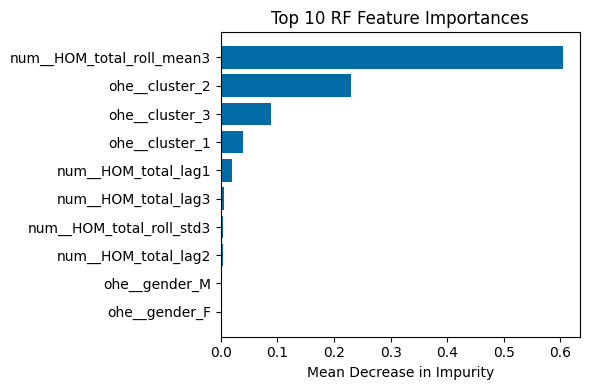

In [ ]:
# cat_names = preproc.named_transformers_['cat'] \
#                   .get_feature_names_out(cat_feats).tolist()

feature_names = preproc_rf.get_feature_names_out()

# 1.2 Pull RF importances
importances = best_rf_pipe.named_steps['rf'].feature_importances_

# 1.3 Build & sort DataFrame
fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

# 1.4 Plot Top 10
plt.figure(figsize=(6,4))
plt.barh(fi['feature'][::-1], fi['importance'][::-1])
plt.title("Top 10 RF Feature Importances")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

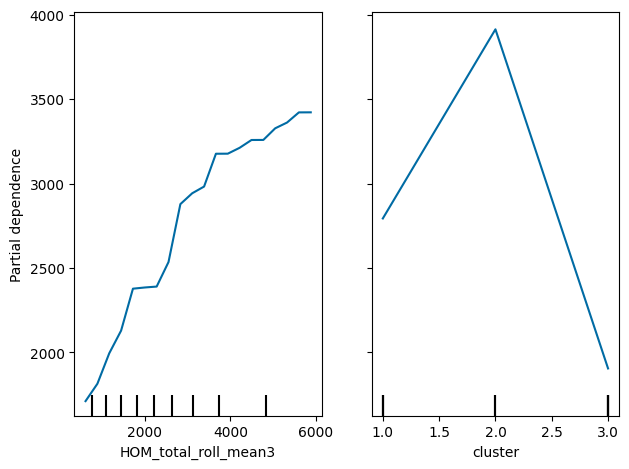

In [ ]:
# 1) X_raw is the DataFrame of the 47 features (before any transform):
X_raw = train.drop(columns=['next_HOM_total'])

# 2) Tell PDP to vary the original "HOM_total_roll_mean3" 
#    and the original "cluster" feature:
features_to_plot = ['HOM_total_roll_mean3', 'cluster']

# 3) Call from_estimator on the full pipeline + raw data:
disp = PartialDependenceDisplay.from_estimator(
    best_rf_pipe,         # your Pipeline(preproc → RF)
    X_raw,           # un-transformed features
    features=features_to_plot,
    kind='average',  # average partial dependence
    grid_resolution=20,
    random_state=42
)

plt.tight_layout()
plt.show()

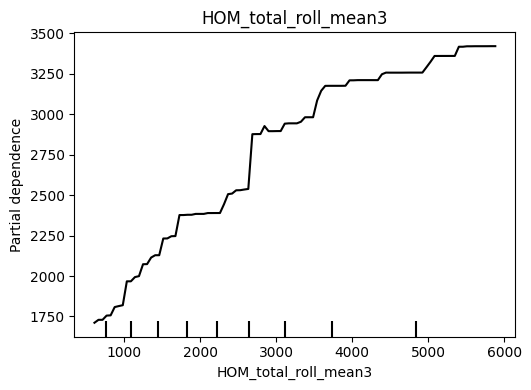

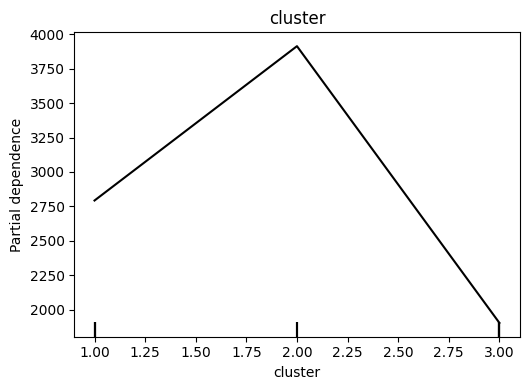

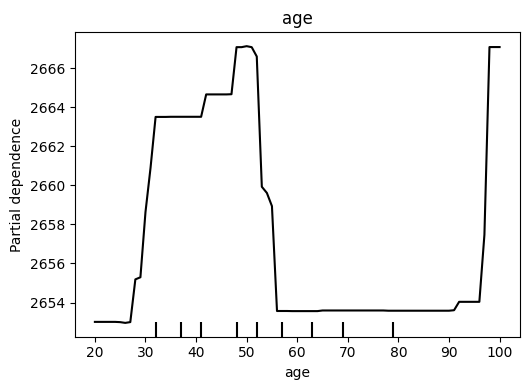

In [ ]:
def plot_pdp_custom(features, model, X_raw, rows=1, cols=2, grid_resolution=100):
    """
    Plot Partial Dependence Plots for specified features with independent y-axis limits.

    Parameters:
    - features: list of feature names (as seen by the raw DataFrame X_raw)
    - model: a fitted Pipeline or estimator with preprocessing built in
    - X_raw: raw feature DataFrame used for prediction
    - rows, cols: grid layout for subplots
    - grid_resolution: number of points to sample along feature axis
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=False)
    axes = axes.flatten()
    
    for ax, feat in zip(axes, features):
        # draw PDP for a single feature on its ax
        PartialDependenceDisplay.from_estimator(
            model,
            X_raw,
            [feat],
            ax=ax,
            kind="average",
            grid_resolution=grid_resolution,
            line_kw={"color": "black"}
        )
        ax.set_title(feat)
        ax.autoscale(enable=True, axis="y")  # independent y-axis scaling

    # hide any unused subplots
    for ax in axes[len(features):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage with your RF model and training set:
X_raw = train.drop(columns=['next_HOM_total'])
features_to_plot = ['HOM_total_roll_mean3', 'HOM_total_roll_std3','age']
plot_pdp_custom(['HOM_total_roll_mean3'], best_rf_pipe, X_raw)
plot_pdp_custom(['cluster'], best_rf_pipe, X_raw)
plot_pdp_custom(['age'], best_rf_pipe, X_raw)

# evaluating model

In [ ]:
model = lin_preds

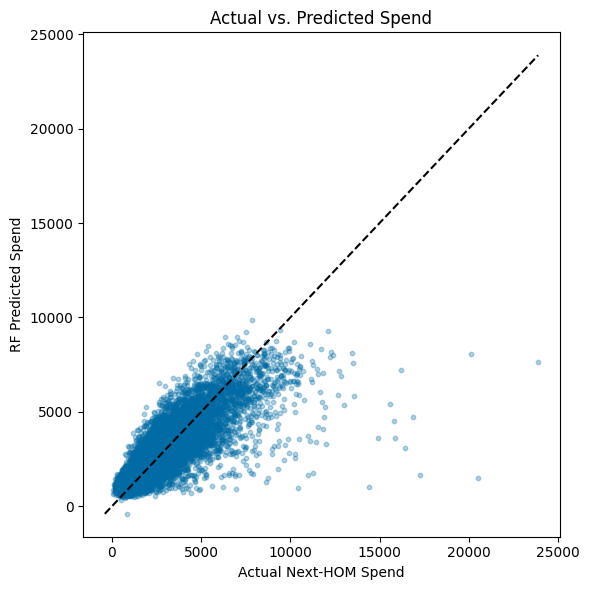

In [ ]:
# actual vs predicted

plt.figure(figsize=(6,6))
plt.scatter(test['next_HOM_total'], model, alpha=0.3, s=10)
lims = [
    min(test['next_HOM_total'].min(), model.min()),
    max(test['next_HOM_total'].max(), model.max())
]
plt.plot(lims, lims, 'k--')  # 45° line
plt.xlabel("Actual Next-HOM Spend")
plt.ylabel("RF Predicted Spend")
plt.title("Actual vs. Predicted Spend")
plt.tight_layout()
plt.show()

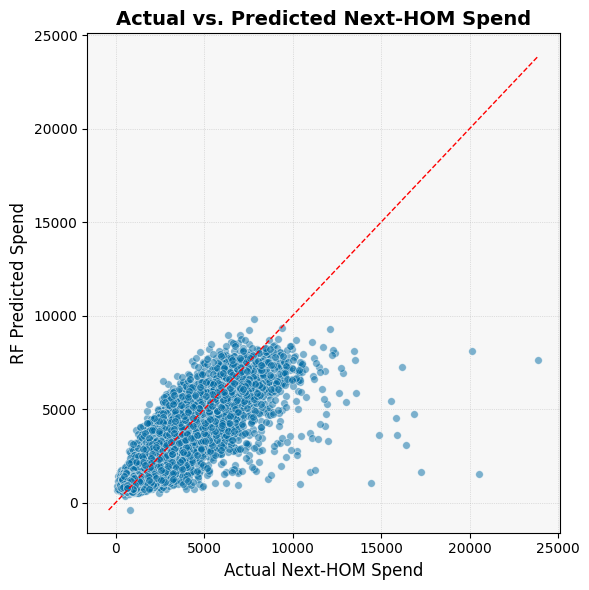

In [ ]:
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(figsize=(6,6))
# Scatter
ax.scatter(
    test['next_HOM_total'], model,
    alpha=0.5, s=30,                 # a bit larger & more opaque
    edgecolor='w', linewidth=0.5     # white outline for each dot
)
# 45° reference line
lims = [
    min(test['next_HOM_total'].min(), model.min()),
    max(test['next_HOM_total'].max(), model.max())
]
ax.plot(lims, lims, '--', color='red', linewidth=1)

# Grid & background
ax.set_facecolor('#F7F7F7')
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)

# Ticks & labels
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel("Actual Next-HOM Spend", fontsize=12)
ax.set_ylabel("RF Predicted Spend", fontsize=12)
ax.set_title("Actual vs. Predicted Next-HOM Spend", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

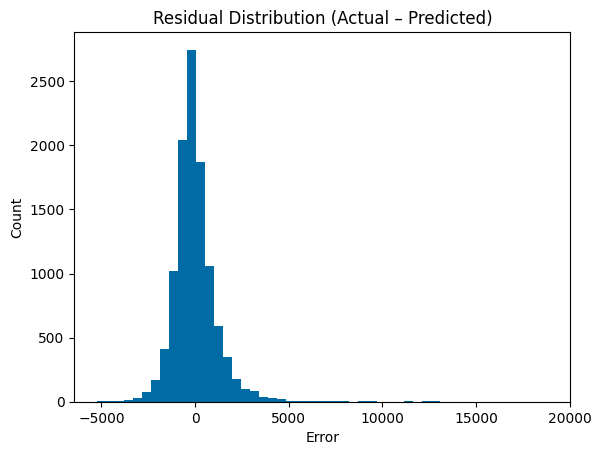

In [ ]:
#resi distribution

resid = test['next_HOM_total'] - model
plt.hist(resid, bins=50)
plt.title("Residual Distribution (Actual – Predicted)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()


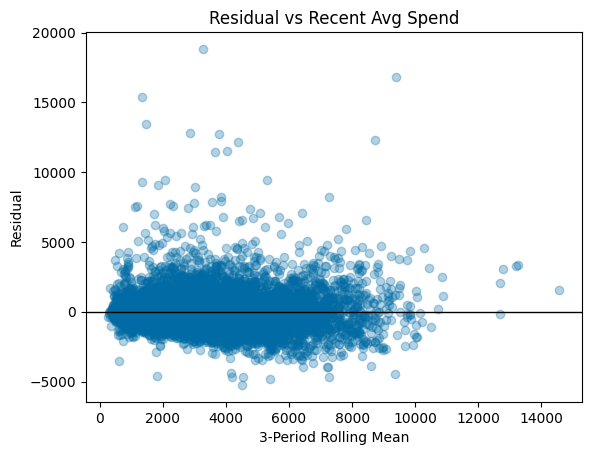

In [ ]:
# resi vs key feature 

plt.scatter(test['HOM_total_roll_mean3'], resid, alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("3-Period Rolling Mean")
plt.ylabel("Residual")
plt.title("Residual vs Recent Avg Spend")
plt.show()


C:\Users\jed jerrel escaran\AppData\Local\Temp\ipykernel_6672\2847680607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['abs_error'] = resid.abs()


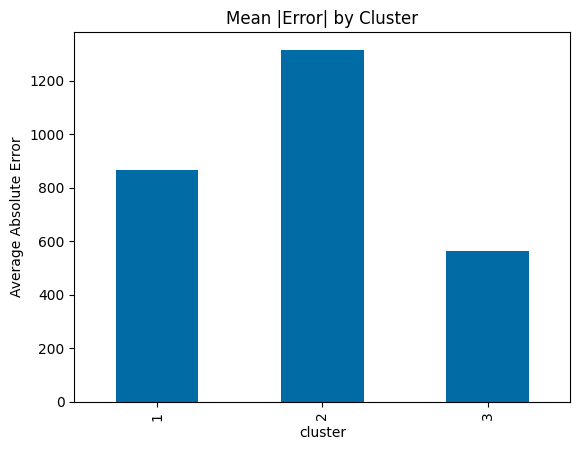

In [ ]:
# error by cluster

test['abs_error'] = resid.abs()
err_by_cluster = test.groupby('cluster')['abs_error'].mean()
err_by_cluster.plot.bar()
plt.title("Mean |Error| by Cluster")
plt.ylabel("Average Absolute Error")
plt.show()


In [ ]:
# # period-level aggregation

# agg = test.assign(
#         rf_pred=rf_pred,
#         lr_pred=lin_preds,
#         rf_pred_tuned = rf_preds
#         ).groupby('HOM_period_date').agg({
#         'next_HOM_total': 'mean',
#         'rf_pred': 'mean',
#         'lr_pred': 'mean',
#         'rf_pred_tuned': 'mean'
# }).reset_index()

# plt.figure(figsize=(10,4))
# plt.plot(agg['HOM_period_date'], agg['next_HOM_total'], label='Actual Mean')
# plt.plot(agg['HOM_period_date'], agg['rf_pred'], label='RF Pred Mean')
# plt.plot(agg['HOM_period_date'], agg['lr_pred'], label='LR Pred Mean')
# plt.plot(agg['HOM_period_date'], agg['rf_pred_tuned'], label='Tuned RF Pred Mean')
# plt.xticks(rotation=90)
# plt.legend()
# plt.title("Average Spend: Actual vs Predicted by Period")
# plt.tight_layout()
# plt.show()


In [ ]:
# agg.to_csv('predictions_by_period.csv', index=False)

In [ ]:
# plt.style.use('tableau-colorblind10')

# fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(agg['HOM_period_date'], agg['next_HOM_total'], 
#         label='Actual Mean Next_HOM', marker='o', linewidth=2)
# ax.plot(agg['HOM_period_date'], agg['rf_pred'],        
#         label='Predicted Mean Next_HOM',  marker='s', linewidth=2, linestyle='--')

# ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.6)
# ax.set_facecolor('#F0F0F0')
# ax.tick_params(axis='x', labelsize=10)
# ax.tick_params(axis='y', labelsize=10)
# ax.legend(frameon=True, facecolor='white', edgecolor='gray')

# ax.set_title("Average Next_HOM Total Spend by Period (Actual vs Predicted)", fontsize=14, weight='bold')
# ax.set_xlabel("Half-Month Period", fontsize=12)
# ax.set_ylabel("Average Spend", fontsize=12)

# plt.tight_layout()
# plt.show()

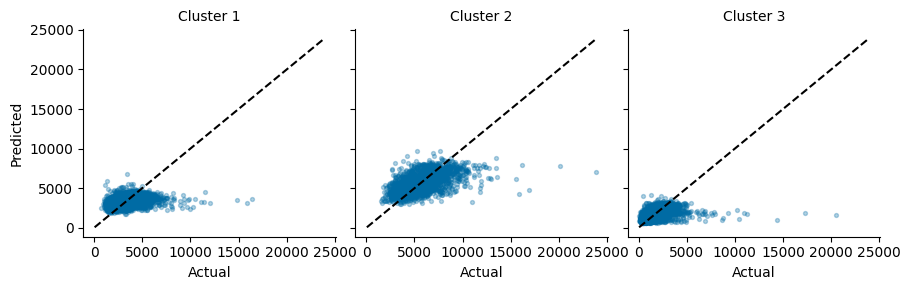

In [ ]:
# faceted by cluster

df_viz = test.copy()
df_viz['model'] = model

# Plot with FacetGrid
g = sns.FacetGrid(df_viz, col="cluster", col_wrap=3, height=3, sharey=True)
g.map(plt.scatter, "next_HOM_total", "model", alpha=0.3, s=8)
g.map(lambda *args, **kw: plt.plot(lims, lims, 'k--'))
g.set_titles("Cluster {col_name}")
g.set_axis_labels("Actual", "Predicted")
plt.tight_layout()
plt.show()
